# QPSO Portfolio Optimization 

## Maybe for a Tier-1 Journal xD ?? not this file tho
## send msg in discord to me to contibute to the real  file (except for any aiub pple)


In [1]:
!pip install yfinance seaborn -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def fetch_real_data(tickers, start_date="2020-01-01", end_date="2025-01-01"):
    print(f"Fetching data for {len(tickers)} assets...")
    data = yf.download(tickers, start=start_date, end=end_date, interval="1d", progress=False)

    prices = None
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.get_level_values(0):
            prices = data['Adj Close']
        elif 'Close' in data.columns.get_level_values(0):
            prices = data['Close']
    else:
        if 'Adj Close' in data.columns:
            prices = data['Adj Close']
        elif 'Close' in data.columns:
            prices = data['Close']

    if prices is None:
        prices = data

    prices = prices.dropna(axis=1, how='all').replace(0.0, np.nan).ffill().dropna()
    print(f"Data shape: {prices.shape}")
    return prices

In [2]:
def map_to_cardinality_weights(raw_particle, k_assets=5):
    """Discrete Cardinality Constraint (K-out-of-N)."""
    dim = len(raw_particle)
    selected_indices = np.argsort(raw_particle)[-k_assets:]
    weights = np.zeros(dim)
    selected_values = raw_particle[selected_indices]
    selected_values = np.maximum(selected_values, 0)
    if np.sum(selected_values) > 0:
        weights[selected_indices] = selected_values / np.sum(selected_values)
    else:
        weights[selected_indices] = 1.0 / k_assets
    return weights

def calculate_mvp_weights(cov_matrix):
    """Analytic Minimum Variance Portfolio Weights."""
    inv_cov = np.linalg.pinv(cov_matrix)
    ones = np.ones(len(cov_matrix))
    w = np.dot(inv_cov, ones)
    return w / np.sum(w)

In [3]:
class PortfolioFitness:
    def __init__(self, returns_df, risk_free_rate=0.03, max_dd_threshold=0.20, penalty_factor=5.0):
        self.returns_df = returns_df
        self.risk_free_rate = risk_free_rate
        self.max_dd_threshold = max_dd_threshold
        self.penalty_factor = penalty_factor
        self.mean_returns = returns_df.mean() * 365
        
    def evaluate(self, weights):
        weights = np.array(weights)
        
        port_series = self.returns_df.dot(weights)
        
        ann_ret = port_series.mean() * 365
        
        negative_rets = port_series[port_series < 0]
        if len(negative_rets) > 0:
            downside_std = negative_rets.std() * np.sqrt(365)
        else:
            downside_std = 1e-6
            
        sortino = (ann_ret - self.risk_free_rate) / (downside_std + 1e-9)
        
        cum_ret = (1 + port_series).cumprod()
        peak = np.maximum.accumulate(cum_ret)
        drawdowns = (cum_ret - peak) / peak
        max_dd = np.abs(drawdowns.min())
        
        penalty = 0
        if max_dd > self.max_dd_threshold:
            penalty = self.penalty_factor * (max_dd - self.max_dd_threshold)
            
        return sortino - penalty


In [4]:
class QPSO:
    def __init__(self, num_particles=30, num_dims=10, max_iter=100, k_cardinality=5,
                 fitness_evaluator=None, alpha_start=1.0, alpha_end=0.5):
        self.n_p = num_particles
        self.dims = num_dims
        self.iter = max_iter
        self.k = k_cardinality
        self.fit_eval = fitness_evaluator
        self.a_start, self.a_end = alpha_start, alpha_end
        self.gbest_pos = None
        self.gbest_fit = -np.inf
        self.history = []

    def optimize(self):
        X = np.random.random((self.n_p, self.dims))
        P = X.copy()
        P_fit = np.array([self.fit_eval.evaluate(map_to_cardinality_weights(x, self.k)) for x in X])

        best_idx = np.argmax(P_fit)
        self.gbest_pos = P[best_idx].copy()
        self.gbest_fit = P_fit[best_idx]

        for t in range(self.iter):
            alpha = self.a_start - (self.a_start - self.a_end) * (t / self.iter)
            mbest = np.mean(P, axis=0)

            phi = np.random.random((self.n_p, self.dims))
            u = np.random.random((self.n_p, self.dims))
            p = phi * P + (1 - phi) * self.gbest_pos
            delta = alpha * np.abs(mbest - X) * np.log(1 / u)
            sign = np.random.choice([-1, 1], size=(self.n_p, self.dims))
            X = p + sign * delta

            for i in range(self.n_p):
                w = map_to_cardinality_weights(X[i], self.k)
                fit = self.fit_eval.evaluate(w)
                if fit > P_fit[i]:
                    P_fit[i] = fit
                    P[i] = X[i].copy()
                    if fit > self.gbest_fit:
                        self.gbest_fit = fit
                        self.gbest_pos = X[i].copy()
            self.history.append(self.gbest_fit)
        return map_to_cardinality_weights(self.gbest_pos, self.k), self.gbest_fit

In [5]:
def run_rolling_backtest(tickers, k=5, window_days=365, rebalance_days=30, tx_cost=0.001):
    prices = fetch_real_data(tickers)
    returns = prices.pct_change().dropna()
    dates = returns.index

    portfolio_val = [10000.0]
    mvp_val = [10000.0]

    weight_history = []
    rebalance_dates = []

    prev_weights = None
    current_weights = np.ones(len(tickers)) / len(tickers)
    current_mvp_weights = calculate_mvp_weights(returns.iloc[:window_days].cov())

    print(f"--- Backtest Start: {dates[window_days].date()} ---")

    for t in range(window_days, len(dates), rebalance_days):
        train_returns = returns.iloc[t-window_days : t]
        evaluator = PortfolioFitness(train_returns)

        qpso = QPSO(num_particles=40, num_dims=len(tickers), max_iter=60,
                    k_cardinality=k, fitness_evaluator=evaluator)
        best_w, _ = qpso.optimize()

        weight_history.append(best_w)
        rebalance_dates.append(dates[t])

        try:
            mvp_w = calculate_mvp_weights(train_returns.cov())
            if np.sum(mvp_w) == 0 or np.isnan(np.sum(mvp_w)): mvp_w = np.ones(len(tickers))/len(tickers)
        except: mvp_w = np.ones(len(tickers))/len(tickers)

        end_t = min(t + rebalance_days, len(dates))
        test_returns = returns.iloc[t : end_t]

        if prev_weights is not None:
            turnover = np.sum(np.abs(best_w - prev_weights))
            portfolio_val[-1] *= (1 - turnover * tx_cost)

        daily_rets = (test_returns * best_w).sum(axis=1)
        for r in daily_rets:
            portfolio_val.append(portfolio_val[-1] * (1 + r))

        daily_rets_mvp = (test_returns * mvp_w).sum(axis=1)
        for r in daily_rets_mvp:
            mvp_val.append(mvp_val[-1] * (1 + r))

        prev_weights = best_w

    return portfolio_val, mvp_val, dates[window_days:], np.array(weight_history), rebalance_dates

Fetching data for 12 assets...
Data shape: (1595, 12)
--- Backtest Start: 2021-08-21 ---


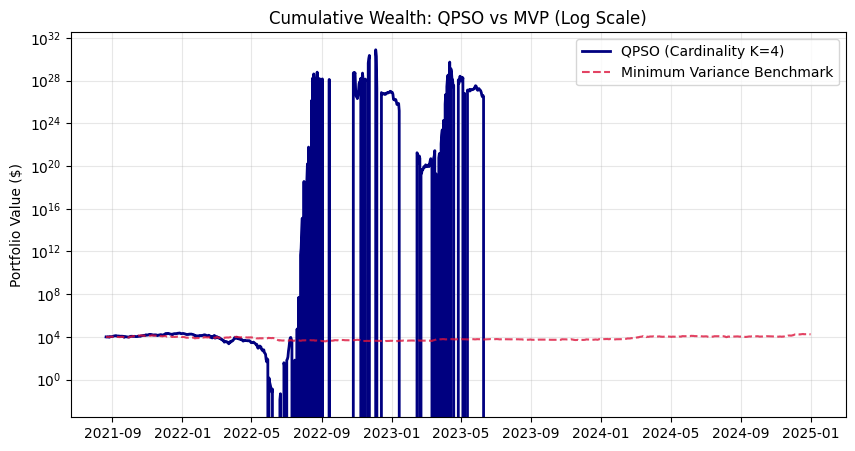

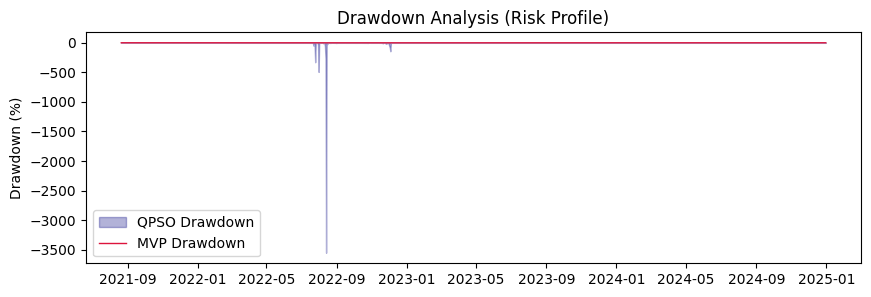

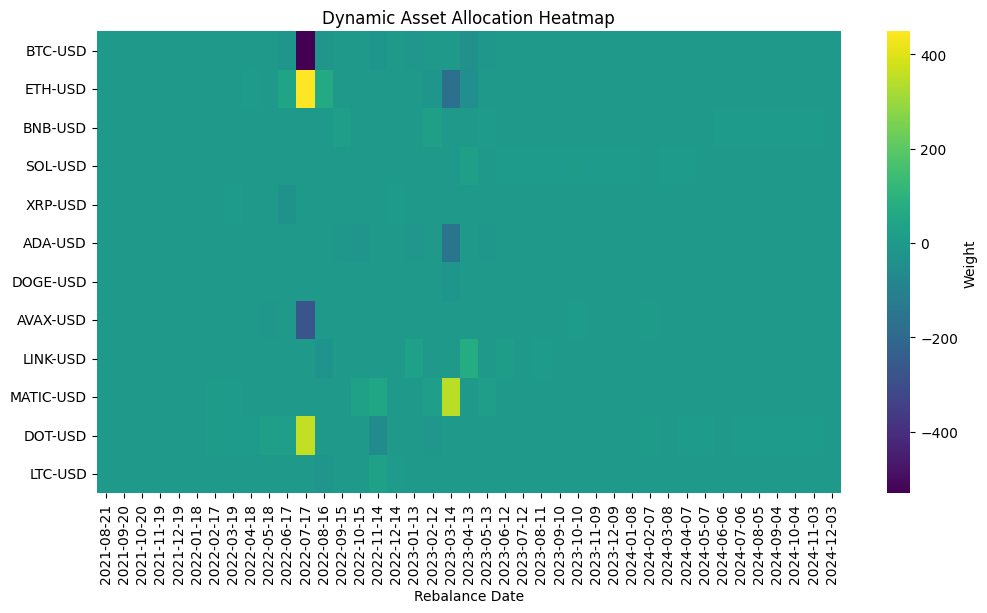

QPSO Values Count: 1229
MVP Values Count: 1229
Fetching Efficient Frontier Data: 2023-12-31 00:00:00 to 2024-12-31 00:00:00
Fetching data for 12 assets...
Data shape: (366, 12)
Generated 1000 random portfolios.
Ploting QPSO Result: Vol=61.04, Ret=-0.95


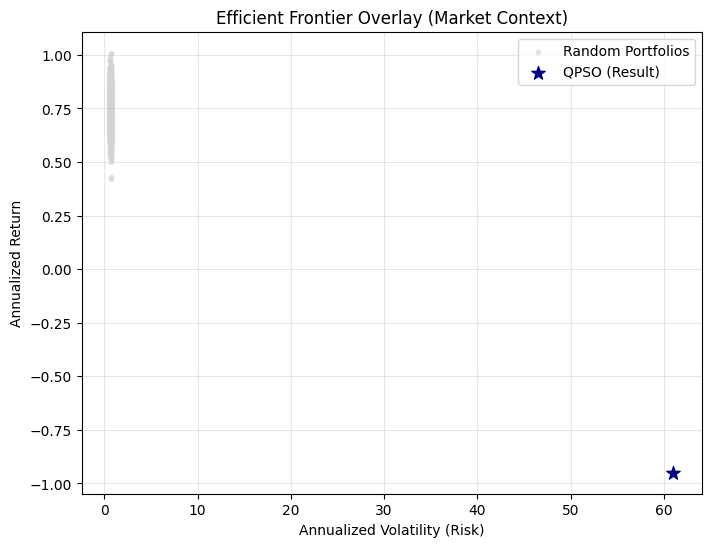

In [6]:
TICKERS = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'ADA-USD',
           'DOGE-USD', 'AVAX-USD', 'LINK-USD', 'MATIC-USD', 'DOT-USD', 'LTC-USD', 'USDC-USD']

q_vals, m_vals, dates, w_hist, reb_dates = run_rolling_backtest(TICKERS, k=6)

min_len = min(len(q_vals), len(m_vals), len(dates))
q_vals, m_vals = q_vals[:min_len], m_vals[:min_len]
dates = dates[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(dates, q_vals, label='QPSO (Cardinality K=4)', color='navy', lw=2)
plt.plot(dates, m_vals, label='Minimum Variance Benchmark', color='crimson', ls='--', alpha=0.8)
plt.yscale('log')
plt.title("Cumulative Wealth: QPSO vs MVP (Log Scale)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

def get_drawdown(p):
    p = np.array(p)
    peak = np.maximum.accumulate(p)
    return (p - peak) / peak

q_dd, m_dd = get_drawdown(q_vals), get_drawdown(m_vals)
plt.figure(figsize=(10, 3))
plt.fill_between(dates, q_dd, 0, color='navy', alpha=0.3, label='QPSO Drawdown')
plt.plot(dates, m_dd, color='crimson', lw=1, label='MVP Drawdown')
plt.title("Drawdown Analysis (Risk Profile)")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
w_df = pd.DataFrame(w_hist, columns=TICKERS, index=[d.date() for d in reb_dates])
sns.heatmap(w_df.T, cmap="viridis", cbar_kws={'label': 'Weight'})
plt.title("Dynamic Asset Allocation Heatmap")
plt.xlabel("Rebalance Date")
plt.show()

plt.figure(figsize=(8, 6))

print(f"QPSO Values Count: {len(q_vals)}")
print(f"MVP Values Count: {len(m_vals)}")

mus, vols = [], []

if len(dates) > 0:
    last_date_of_backtest = dates.max()
else:
    print(" Warning: No dates in backtest result. Defaulting to today.")
    import pandas as pd
    last_date_of_backtest = pd.Timestamp.now()

ef_start_date = last_date_of_backtest - pd.DateOffset(years=1)
print(f"Fetching Efficient Frontier Data: {ef_start_date} to {last_date_of_backtest}")

try:
    ef_prices = fetch_real_data(TICKERS, start_date=ef_start_date, end_date=last_date_of_backtest)

    if ef_prices is None or ef_prices.empty:
        print(" Error: Efficient Frontier prices dataframe is empty.")
    else:
        ef_returns = ef_prices.pct_change().dropna()
        if ef_returns.empty:
             print(" Error: Efficient Frontier returns are empty.")
        else:
            ef_mean_returns = ef_returns.mean() * 365
            ef_cov_matrix = ef_returns.cov() * 365

            for _ in range(1000):
                w = np.random.random(len(TICKERS)); w /= w.sum()
                ret = np.dot(w, ef_mean_returns)
                vol = np.sqrt(np.dot(w.T, np.dot(ef_cov_matrix, w)))
                mus.append(ret); vols.append(vol)

            print(f"Generated {len(mus)} random portfolios.")

            if len(mus) > 0:
                plt.scatter(vols, mus, c='lightgray', s=10, alpha=0.5, label='Random Portfolios')
            else:
                print(" Warning: Generated portfolios list is empty.")

except Exception as e:
    print(f" Exception during Efficient Frontier generation: {e}")

if len(q_vals) > 0:
    q_ret_yr = (q_vals[-1]/q_vals[-365] - 1) if len(q_vals) > 365 else (q_vals[-1]/q_vals[0] - 1)
    if len(q_vals) > 1:
        q_vol_yr = np.std(pd.Series(q_vals).pct_change()) * np.sqrt(365)
    else:
        q_vol_yr = 0

    print(f"Ploting QPSO Result: Vol={q_vol_yr:.2f}, Ret={q_ret_yr:.2f}")
    plt.scatter(q_vol_yr, q_ret_yr, c='navy', s=100, marker='*', label='QPSO (Result)')
else:
    print(" QPSO values empty, skipping star marker.")

plt.title("Efficient Frontier Overlay (Market Context)")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
print("\n--- Running Statistical Robustness Test (30 Runs) ---")
full_data = fetch_real_data(TICKERS, start_date="2023-01-01", end_date="2024-01-01")
eval_full = PortfolioFitness(full_data.pct_change().dropna())

kpso_sharpes = []
for i in range(30):
    q = QPSO(num_particles=30, num_dims=len(TICKERS), max_iter=40, k_cardinality=4, fitness_evaluator=eval_full)
    _, best_s = q.optimize()
    kpso_sharpes.append(best_s)
    if (i+1)%10==0: print(f"Run {i+1}/30 completed...")

t_stat, p_val = stats.ttest_1samp(kpso_sharpes, 1.2)

print(f"\nMean QPSO Sharpe: {np.mean(kpso_sharpes):.4f} (Std: {np.std(kpso_sharpes):.4f})")
print(f"P-Value (vs Baseline=1.2): {p_val:.6e}")
if p_val < 0.05 and np.mean(kpso_sharpes) > 1.2:
    print(" Result is Statistically Significant (p < 0.05)")
else:
    print(" Result not significant.")


--- Running Statistical Robustness Test (30 Runs) ---
Fetching data for 12 assets...
Data shape: (365, 12)
Run 10/30 completed...
Run 20/30 completed...
Run 30/30 completed...

Mean QPSO Sharpe: 3.3424 (Std: 0.2282)
P-Value (vs Baseline=1.2): 7.808233e-30
✅ Result is Statistically Significant (p < 0.05)
